In [100]:
import math
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from lora_module import LoraTraining
from peft import LoraConfig, TaskType, get_peft_model
from remote_module import CustomConv1D
from torch.nn import Embedding
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Conv1D,
    DataCollatorForLanguageModeling,
    TextDataset,
    Trainer,
    TrainingArguments,
)

from concrete.ml.torch.hybrid_model import HybridFHEModel

SEED = 0
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

In [101]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

In [102]:
def generate_text(prompt, model, tokenizer, max_new_tokens=30):
    # Encode the input prompt
    inputs = tokenizer.encode_plus(prompt, return_tensors="pt")

    # Generate text
    output = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=0.95,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [103]:
# Example usage
prompt = "What is FHE ?"
generated_text = generate_text(prompt, model, tokenizer)
print(generated_text)

What is FHE? FH: A basic program that is used to calculate the height of an object, and then sets the minimum height to be the object's height.


In [104]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=32,
    lora_dropout=0.05,
    fan_in_fan_out=True,
)

peft_model = get_peft_model(model, peft_config)

In [105]:
def replace_conv1d(module, module_index_to_skip=0):
    for name, child in module.named_children():
        if isinstance(child, Conv1D):

            # Skip the module if the index has not been reached, and decrement the index
            if module_index_to_skip >= 0:
                module_index_to_skip -= 1
            else:
                custom_linear = CustomConv1D(child.weight, bias=child.bias)
                setattr(module, name, custom_linear)
        else:
            module_index_to_skip = replace_conv1d(child, module_index_to_skip=module_index_to_skip)

    return module_index_to_skip


# Gradients of the first base layer that is used for fine-tuning are not needed. We
# therefore need to exclude the backward module from the remote_names since calibration
# won't get through it (which raises an issue with hybrid models)
replace_conv1d(peft_model, module_index_to_skip=0);

In [106]:
GRADIENT_ACCUMULATION_STEPS = 2

lora_training = LoraTraining(peft_model, GRADIENT_ACCUMULATION_STEPS)

In [107]:
BLOCK_SIZE = 128

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="data_finetune/what_is_fhe.txt",
    block_size=BLOCK_SIZE,
    cache_dir="cache_dataset",
)

In [108]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

EPOCHS = 2
PER_DEVICE_TRAIN_BATCH_SIZE = 4

training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    save_total_limit=1,
    use_cpu=True,
    learning_rate=5e-4,
    logging_strategy="epoch",
    optim="adamw_torch",
    seed=SEED,
    data_seed=SEED,
    weight_decay=0.0,
    warmup_steps=0,
    max_grad_norm=1.0,
)

In [109]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

train_dataloader = trainer.get_train_dataloader()

len_dataloader = len(train_dataloader)
num_update_steps_per_epoch = len_dataloader // training_args.gradient_accumulation_steps
num_update_steps_per_epoch = max(num_update_steps_per_epoch, 1)
max_steps = math.ceil(training_args.num_train_epochs * num_update_steps_per_epoch)

trainer.create_optimizer_and_scheduler(num_training_steps=max_steps)

lora_training.update_training_parameters(trainer.optimizer, trainer.lr_scheduler, training_args)

In [110]:
def get_remote_names(model):
    remote_names = []
    for name, module in model.named_modules():
        # Some gradients are not needed for fine-tuning, so need to exclude the backward module
        # from the remote_names since calibration won't get through it (which raises an issue with
        # hybrid models). We however still need to include the associated module's forward pass in
        # the hybrid model
        # Also include the embedding and language model head as they represent a lot of the model's
        # parameters
        if isinstance(module, (Conv1D, Embedding)) or "lm_head" in name:
            remote_names.append(name)

        elif isinstance(module, CustomConv1D):
            remote_names.append(name + ".forward_module")
            remote_names.append(name + ".backward_module")

    return remote_names


remote_names = get_remote_names(lora_training)

In [113]:
hybrid_model = HybridFHEModel(lora_training, module_names=remote_names)

In [41]:
input_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)
label_tensor = torch.randint(0, 2, (PER_DEVICE_TRAIN_BATCH_SIZE, BLOCK_SIZE)) * (
    tokenizer.vocab_size - 1
)

inputset = (input_tensor, label_tensor)

In [42]:
hybrid_model.model.toggle_calibrate(enable=True)

hybrid_model.compile_model(
    inputset,
    n_bits=8,
    rounding_threshold_bits={"n_bits": 6, "method": "approximate"},
    p_error=1e-5,
)

hybrid_model.model.toggle_calibrate(enable=False)

Training Progress:   0%|          | 0/100 [3:32:36<?, ?it/s]


In [43]:
def train_custom_model(hybrid_model, train_dataloader, training_args, fhe="disable"):
    device = "cpu"
    hybrid_model.model.to(device)

    # Training loop
    hybrid_model.model.inference_model.train()

    total_epochs = int(training_args.num_train_epochs)
    epoch_pbar = tqdm(total=total_epochs, desc="Training Progress", position=0)

    total_batched_samples = 0
    epoch_losses = []  # List to store the loss for each epoch

    for epoch in range(total_epochs):
        total_loss = 0
        grad_norms = []

        steps_in_epoch = len(train_dataloader)
        for step, batch in enumerate(train_dataloader):
            total_batched_samples += 1

            batch = {k: v.to(device) for k, v in batch.items()}

            # Gradient accumulation
            is_last_batch_step = (
                steps_in_epoch <= training_args.gradient_accumulation_steps
                and (step + 1) == steps_in_epoch  # noqa: W503
            )
            accumulate_gradients = (
                total_batched_samples % training_args.gradient_accumulation_steps == 0
            )

            run_optimizer = is_last_batch_step or accumulate_gradients

            hybrid_model.model.toggle_run_optimizer(enable=run_optimizer)

            loss, grad_norm = hybrid_model((batch["input_ids"], batch["labels"]), fhe=fhe)

            total_loss += loss.item()

            if grad_norm is not None:
                grad_norms.append(grad_norm)

        # Get current learning rate
        current_lr = hybrid_model.model.lr_scheduler.get_last_lr()[0]

        # Get last grad norm
        current_grad_norm = grad_norms[-1]

        # Store the total loss for this epoch
        epoch_losses.append(total_loss)

        # Log epoch results
        print(
            f"Epoch {epoch + 1}/{training_args.num_train_epochs}, "
            f"Loss: {total_loss:.4f}, grad norm: {current_grad_norm}, lr: {current_lr}"
        )

        epoch_pbar.update(1)

    # Save model checkpoint
    if training_args.output_dir is not None:
        save_path = f"{training_args.output_dir}/checkpoint-{epoch + 1}"
        hybrid_model.model.inference_model.save_pretrained(save_path)

    epoch_pbar.close()

    # Plot the loss evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_epochs + 1), epoch_losses, marker="o")
    plt.title("Loss Evolution During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.grid(True)
    plt.show()

Training Progress:  50%|█████     | 1/2 [05:02<05:02, 302.53s/it]

Epoch 1/2, Loss: 1.8475, grad norm: 0.17272646725177765, lr: 0.00025


Training Progress: 100%|██████████| 2/2 [10:16<00:00, 309.43s/it]

Epoch 2/2, Loss: 1.8335, grad norm: 0.22119106352329254, lr: 0.0


Training Progress: 100%|██████████| 2/2 [10:17<00:00, 308.74s/it]


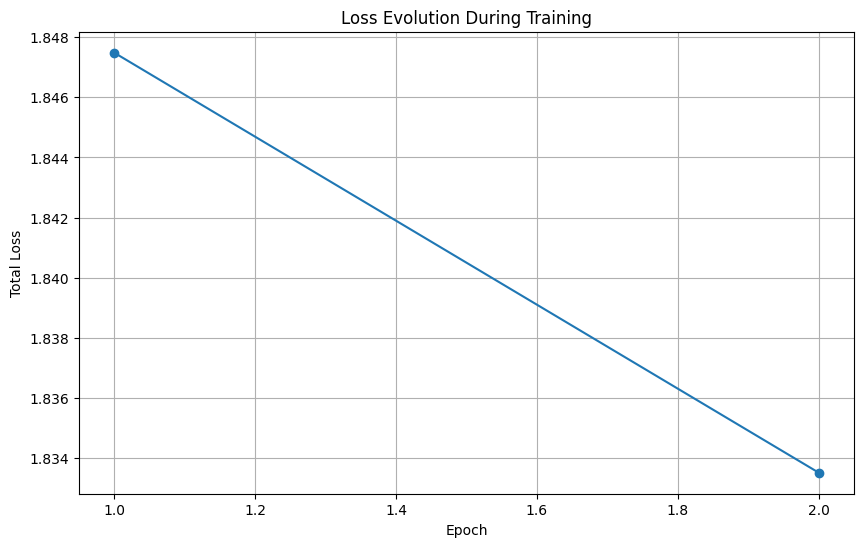

In [44]:
# Avoid the following error from HuggingFace when training :
# "The current process just got forked, after parallelism has already been used. Disabling
# parallelism to avoid deadlocks..."
tokenizer.parallelism = False

train_custom_model(hybrid_model, train_dataloader, training_args, fhe="disable")

In [45]:
fine_tuned_model = hybrid_model.model.inference_model

# In simulation, we can only generate a single token at a time because of fixed size circuits
# and how `generate` works (only the last token from the previous generation is kept)
hybrid_model.set_fhe_mode("disable")

In [46]:
prompt = "What is FHE ?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

What is FHE?? I am a doctor and have a Doctor? My doctor is a psychiatrist and I have done a research into my daughter who I read the paper I


In [47]:
peft_model.disable_adapter_layers()

prompt = "What is FHE ?"
generated_text = generate_text(prompt, fine_tuned_model, tokenizer)
print(generated_text)

peft_model.enable_adapter_layers()

What is FHE?, and I think it is a C-, C, F- and G, I believe it's is not a, O'B, B


In [48]:
def print_weights_and_size(model, print_detail=False):
    total_weights = 0
    total_lora_weights = 0
    for name, param in model.named_parameters():
        total_weights += param.numel()

        if "lora" in name:
            total_lora_weights += param.numel()

        if print_detail:
            print(name, param.numel())

    print(f"Total number of weights: {total_weights}")
    print(f"Total number of LoRA weights: {total_lora_weights}")

    return total_weights

In [49]:
total_weights_size = print_weights_and_size(hybrid_model.model)

Total number of weights: 124587264
Total number of LoRA weights: 147456


In [50]:
path = Path("deployment/gpt2_lora_finetuned")
path.mkdir(parents=True, exist_ok=True)

if path.is_dir() and any(path.iterdir()):
    shutil.rmtree(path)

hybrid_model.save_and_clear_private_info(path)

In [51]:
total_weights_size_private = print_weights_and_size(hybrid_model.model)

Total number of weights: 38783232
Total number of LoRA weights: 147456


In [52]:
print(
    "Total weights removed: "
    f"{(total_weights_size - total_weights_size_private) / total_weights_size * 100:.2f} %"
)

Total weights removed: 68.87 %
